In [3]:
# EXECUTE FIRST
import GAUtilities as ga # this is a local package

# computational imports
import numpy as np
import pandas as pd

from scipy.optimize import minimize
import json
from simanneal import Annealer

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# display import
from IPython.display import display, IFrame
from IPython.core.display import HTML

# for playing videos, customize height and width if desired
def play_video(vid_name, w=640, h=360):
    vid_path = "https://media.uwex.edu/content/ds/ds775_r19/" + vid_name + "/index.html"
    hlink = '<a href = ' + vid_path + ' target = """_blank""">Open video in new tab</a>'
    display(IFrame(vid_path, width=w, height=h))
    display(HTML(hlink))

# for this notebook we get rid of a bunch of warnings that don't hurt anything
import warnings
warnings.filterwarnings('ignore')

from time import time

# Lesson 7 - Global Optimization 2 - Genetic Algorithms

Genetic algorithms are another example of metaheuristic global optimization. Think of a genetic algorithm as a smart version of random search.  Genetic algorithms are great at exploring large search spaces, but sometimes aren't so good at zeroing in on a solution once they've gotten close to a good solution.

You should have read about the basics of genetic algorithms in the textbook.  Genetic algorithms are a vast subject, and we'll just scratch the surface.  Fortunately, there seem to be tons of free tutorials and other resources available for learning more about genetic algorithms.  The pseudocode for a genetic algorithm is as follows:
```
generate the initial population
compute fitness
repeat
    selection
    crossover
    mutation
    elitism (optional)
    compute fitness
until population has converged
```

Here are just a few notes about the algorithm:
* population = set of trial solutions that are also called individuals (or chromosomes)
* fitness = objective function
* selection = choosing the most promising solutions in the current population but leaving a few bad ones for diversity
* crossover = combining or breeding the selected solutions to generate new candidate solutions
* mutation = randomly tweaking some solutions in the current population to encourage exploration of the solution space

In terms of the **exploration and exploitation tradeoff** one can think of selection as being exploitation (local search) and crossover and mutation as being exploration (global search).  Changing the parameters used in selection, crossover, and mutation changes the balance between exploration and exploitation.


We will write our own genetic algorithm so that we can get a better understanding of their ingredients.  Before we dive into the details, we summarize some packages you could explore to apply genetic algorithms to your optimization problems.

## Population Based Algorithms

Genetic algorithms are an important example of a population based algorithm.  Note that in the previous methods we've studied:  local search, simulated annealing, and Bayesian optimization, we focus on updating a single point by using historical information from previous points.  In a population based algorithm, a set of points, called a population, is iteratively updated together to progress toward an optimal point.  In a genetic algorithm, rules inspired by natural evolution are used to update the population of potential solutions.  There are also many other population based algorithms such as Particle Swarm Optimization, Differential Evolution, and Evolution Strategies, where the latter includes genetic algorithms.  Genetic algorithms are a very flexible and popular population based method that can work over many problems and variable types.  <a href="https://bdataanalytics.biomedcentral.com/articles/10.1186/s41044-016-0003-3">Here is a survey</a> of population based optimization algorithms in data science if you'd like to explore further on your own.

## Genetic Algorithm Packages

If you need to use genetic algorithms in practice, it's probably better to seek out a package that has that functionality.  Some options include:
* <a href="https://github.com/deap/deap" target="_blank">The `DEAP` package</a>.  This package is for genetic programming.  It's very powerful and flexible, but also abstract with a significant learning curve.  It's worth learning if you often need to use genetic algorithms or other types of evolutionary algorithms.
* <a href="https://pypi.org/project/geneticalgorithm/" target="_blank">The `geneticalgorithm` package</a> This package is an easy to use, but limited, genetic algorithm for minimization.  It supports either real or integer variables.  It can't be used for problems with permutations such as TSP.  Also, the objective function can have only one argument so if you need additional data (e.g. the distance matrix) the function will have to find the data in the global scope.  It's slow with the default settings.
* The `deap_wrapper` package.  This is something we've been working on but at the moment it's not a well documented package.  If you're curious, you can see examples of how to use it in the notebook `deap_wrapper_examples.ipynb` in the same folder as this lesson.
* The `GA` package in R.  This is a really easy to use implementation of the genetic algorithms that handles several types of variables.  Documentation is <a href="https://cran.r-project.org/web/packages/GA/" target="_blank">here on CRAN</a>.  In our experience this is a lot easier to use than `DEAP`.  The notebook `Genetic_Algorithm_with_R.ipynb` gives an example and shows how you can include R in a Python Jupyter notebook (it's pretty cool).

**For more help go here:** A fantastic place to get more details about genetic algorithms and the various bits and pieces is this <a href="https://www.tutorialspoint.com/genetic_algorithms/index.htm" target="_blank">free online tutorial at tutorialspoint.com.</a>


## Genetic Algorithm Step by Step

We'll write a genetic algorithm to minimize a simple dice toss game. In our game, we want to get the lowest possible total in a toss of three dice. Before we look at code, let's first introduce the concepts of genetic algorithms with a hands-on version of our game.

In [4]:
# execute for video
play_video("ds775_lesson7_genetic-algorithm-intro")

### Dice Game Code

Let's see how our game translates into code. We'll break it down in just a bit, but first, let's take a look at the complete algorithm. Go ahead and run this code multiple times to see how quickly the genetic algorithm finds the optimal solution.  (Note:  this uses code we've supplied in `GAUtilities.py` which is in the same directory as this notebook and is loaded in the first cell of the notebook.)

In [5]:
pop_size = 6 # should be even due to the way we'll implement crossover
ind_size = 3 # determines number of decision variables within each individual
bounds = [1,7] #range of integers. remember for integers, you need to go one over the number you really want
tourn_size = 2 # tournament size for selection
cx_prob = 0.8 # probability a pair of parents crossover to produce two children
mut_prob = 0.2 # probability an individual mutates
ind_prob = 0.1 # probability each variable in an individual mutates
num_iter = 200 # number of genetic algorithm mutations
update_iter = 20 # how often to display output


# objective or fitness function. 
#It's not important this is defined in this spot, just that it's defined somewhere before the code below
def obj_sumDice(x):
    x = np.array(x) # force a numpy arrray here so that the math below works
    return np.sum(x)

#initialize population and fitness
pop = np.random.randint(low=bounds[0], high=bounds[1], size =(pop_size,ind_size))
fitness = ga.computeFitness(obj_sumDice, pop)

# initialize stats and output
stats, best_fitness, best_x = ga.initStats(fitness, pop, num_iter)

#This is where the guts of the algorithm start
for iter in range(num_iter):
    
    # tournament selection
    pop = ga.sortPop(pop, fitness)#sort population
    selected_pop = ga.tournamentSelection(pop, tourn_size).astype(int)

    # one-point crossover (mating)
    cx_pop = ga.onePointCrossover(selected_pop, cx_prob).astype(int)

    # uniformIntMutation
    #note that bounds should be an array and we need to pass back ints because this is an integer problem
    mut_pop = ga.uniformIntMutation(cx_pop, mut_prob, ind_prob, bounds)
    
    #choose one of the following two options, based on the complexity of your problem
    # copy mutated pop
    pop = mut_pop.copy()
    #or run elitism
    #pop = ga.addElitism(pop, mut_pop, 1)
    
    #re-calculate fitness
    fitness = ga.computeFitness(obj_sumDice, pop)
    
    # collect stats and output to screen
    stats, best_fitness, best_x = ga.updateStats(stats, fitness,best_x, pop, iter, update_iter)


#####################
# Everything in the algorithm is done, and now we're just outputting the final result
#####################
print(f"The minimum value found of dice total is {best_fitness:.0f}")
print("The location of that minimum is:")
print('(',', '.join(f"{x:.0f}" for x in best_x),')')

Iteration | Best this iter |    Best ever
        1 |      4.000e+00 |    4.000e+00
       20 |      4.000e+00 |    4.000e+00
       40 |      4.000e+00 |    4.000e+00
       60 |      4.000e+00 |    4.000e+00
       80 |      4.000e+00 |    3.000e+00
      100 |      4.000e+00 |    3.000e+00
      120 |      4.000e+00 |    3.000e+00
      140 |      3.000e+00 |    3.000e+00
      160 |      3.000e+00 |    3.000e+00
      180 |      3.000e+00 |    3.000e+00
      200 |      3.000e+00 |    3.000e+00
The minimum value found of dice total is 3
The location of that minimum is:
( 1, 1, 1 )


Now watch this video where we step through the code above

In [6]:
# execute for video
play_video("ds775_lesson7_genetic-code-walkthrough")

This is a relatively easy problem for the genetic algorithm to solve. You can see that even with this small population, it takes less than 200 iterations to solve. We're solving a small problem so it's easier to demonstrate the code to you step-by-step. If you'd like to experiment with solving a larger problem, increase the individual size. You'll most likely need to also increase the population size and number of iterations, as well. You can also tinker with the various probabilities to increase or decrease the randomness (exploration).

## GA Steps
Let's take a look at what's happening in each step, starting with initialization.

### Generate the Initial Population
We'll have an initial population of 6 individuals (sometimes called chromosomes), each with 3 genes (or decision variables). We're using numpy arrays extensively in this lesson. All of your populations should be numpy arrays.

In each population, the individuals are stored as the rows of the array, and the columns represent each gene in each individual.

In [7]:
np.random.seed(10101010) #for everything, everything, everything... (Courtesy of the Violent Femmes)
pop_size = 6 # should be even due to the way we'll implement crossover
ind_size = 3 #this is the number of genes in each individual

#bounds are used for both real and integer problems. 
#For integer problems, the upper bound should be 1 over what you actually want
bounds = [1,7]

#each type of problem might use different types of populations. This one is a simple matrix of integers.
pop = np.random.randint(low=bounds[0], high=bounds[1], size =(pop_size,ind_size))

Let's print out the population to see what we have. Remember, each row is an individual, and each value within that row represents each decision variable in that individual.

In [8]:
pop

array([[2, 3, 4],
       [3, 6, 4],
       [2, 3, 4],
       [6, 4, 5],
       [6, 2, 5],
       [4, 1, 2]])

### Compute Fitness

We want to apply the objective function to each individual or row in the numpy array `pop`. 

We've created a helper function that let's you compute the fitness. It takes in the fitness function, the population, and any other keyword arguments you might need. A keyword argument is a named argument, such as `dist_mat=dist_mat`. You won't need any keyword arguments for this problem, but you will for other problems. All of our functions are documented, and you can read the documentation by putting a ? before the function name in a code cell and running it. Try it below.

In [9]:
#see the documentation for the computeFitness function in the ga module
?ga.computeFitness

Signature: ga.computeFitness(f, pop, **kwargs)
Docstring:
Computes fitness based on passed in function.

Parameters:
f (function, required): the function used to evaluate fitness
pop (numpy array, required): the population on which to evaluate fitness - individuals in rows.
**kwargs (named arguments, optional): additional arguments that will be passed through to the fitness function

Returns a numpy array of computed fitnesses.
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


Reminder: we use the prefix `obj_` to identify objective functions. In the genetic algorithm world, our objective functions determine the `fitness` of each individual.

In [10]:
#this is our objective function for this particular problem. Each problem requires a different objective function.
def obj_sumDice(x):
    x = np.array(x) # force a numpy arrray here so that the math below works
    return np.sum(x)

#compute the fitness by passing in the function and population
fitness = ga.computeFitness(obj_sumDice, pop)


Let's print out the fitness values. These correspond to each row in our population. We have six rows (6 individuals) and each one has a fitness value.

In [11]:
fitness

array([ 9., 13.,  9., 15., 13.,  7.])

#### Self Assessment: Using Maximization with GA

Our genetic code only performs minimization. It's common with optimization code to only optimize in one direction - either maximizing or minimizing. It's easy for people using the algorithm to switch the direction of the optimization by altering the objective function. Alter the objective function above to maximize the sum of the dice.

### Selection

We want to select the fittest individuals from the population for breeding (crossover and mutation), but we also want to maintain diversity in the population so that breeding produces a variety of offspring to encourage exploration of the search space. Unlike in real breeding, our population size will remain constant, so our selected individuals will replace the initial individuals in the population. (Note: more sophisticated algorithms allow the population size to fluctuate.)

We'll implement **tournament selection** where we'll first choose a subset of individuals from the population and then select the fittest member of that subset for the new population.  The number of individuals in each subset is called the tournament size.  The larger the size of the tournament, the more likely that only the fittest members of the population are selected for the next generation.  Small tournament sizes mean that less fit individuals have a chance to be selected.  We'll use a `tourn_size = 2`.  You can read a bit about other selection operators in any genetic algorithms textbook.  A small explanation about some selection operators can be found on <a href="https://en.wikipedia.org/wiki/Selection_(genetic_algorithm)#d._Tournament_Selection">Wikipedia.</a>

To do our implementation of tournament selection, first we have to sort our population by fitness. We've made that easy to do with a single line of code.

In [12]:
#review the documentation for sortPop
?ga.sortPop

Signature: ga.sortPop(pop, fitness)
Docstring:
Sorts a population with minimal fitness in first place.

Parameters:
pop (numpy array, required): The population to sort, individuals in rows
fitness (numpy array, required): The values used to sort the population

Returns:
Sorted numpy array of population
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


In [13]:
pop = ga.sortPop(pop, fitness)#sort population
pop

array([[4, 1, 2],
       [2, 3, 4],
       [2, 3, 4],
       [3, 6, 4],
       [6, 2, 5],
       [6, 4, 5]])

Once we've sorted our population, we'll randomly choose 2 integers between 0 and the population size, (say 3 and 6) and have a tournament between those two individuals.  Since the individual in row 3 is the fittest (in the sorted population) we'll select that individual.

To do the tournament selection, you can simply call our tournament selection helper function. The function has a parameter called "debug." If we run it with `debug=True`, we can see which individuals went competed in a tournament, and of those, which were selected.

In [14]:
#review the documentation for tournamentSelection
?ga.tournamentSelection

Signature: ga.tournamentSelection(pop, tourn_size, debug=False)
Docstring:
Implements tournameent selection on a population.

Parameters:
pop (numpy array, required): The sorted population from which selections will be drawn.
tourn_size (between 2 and population size, required): The number of individuals that will compete in each tournament
debug (boolean, optional, default=False): Flag to indicate whether to output debugging print statements.

Returns:
Numpy Array of the selected population.
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


Since this is an integer problem, we cast the result to integers using .astype(int). If you did not add this code, you would receive floats back.

*Note: debug is great if you're doing a small problem. If you use debug=True on a large problem, you will have a lot of output. You can just call the function without debug passed in, as the default is False.)*

In [15]:
tourn_size = 2
selected_pop = ga.tournamentSelection(pop, tourn_size, debug=True).astype(int) 

Individuals in tournament: [5 0]
Individual selected: 0
Individuals in tournament: [3 2]
Individual selected: 2
Individuals in tournament: [5 2]
Individual selected: 2
Individuals in tournament: [0 1]
Individual selected: 0
Individuals in tournament: [4 3]
Individual selected: 3
Individuals in tournament: [1 4]
Individual selected: 1


If you look at the fitness values from the original population and the selected population fitness values, you should notice that there are fewer large values and more small values in the selected population.  You may also see that there are repeated values because the fittest individuals may be selected more than once.  That's selection in action.

In [16]:
print('Original fitness\n', fitness)
#get the new fitness
selected_fitness = ga.computeFitness(obj_sumDice, selected_pop)
print('Selected fitness\n', selected_fitness)

Original fitness
 [ 9. 13.  9. 15. 13.  7.]
Selected fitness
 [ 7.  9.  9.  7. 13.  9.]


#### *Self-Assessment:  Exploring Tournament Selection*

Try running the tournament selection code above with both smaller and larger tournament sizes.  What happens for smaller tournament sizes?  For larger tournament sizes?  For tournament size 1?  What if the tournament size the same as the population size?  How does tournament size impact selection? (Feel free to make a bigger population to play with.)


### Crossover (Mating)

At this point, the individuals in `select_pop` are in a random order after selection (if they weren't then we should shuffle them before continuing) so we're going to loop over pairs of individuals and with probability `cx_prob = 0.8` each pair will produce a pair of offspring using <a href="https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)"> One Point Crossover </a> (<a href="https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)">other kinds of crossover</a> are possible too) We randomly choose a "crossover point" and swap the two pieces of the two individuals.  The image below illustrates this nicely:

<img src="./images/OnePointCrossover.png" width=400>

In the next cell is a bit of Python that illustrates how One Point Crossover works when the crossover point is 3.

In [17]:
parent1 = np.arange(10) + 10 # use sequences to make it easy to see crossover
parent2 = parent1 + 10

child1, child2 = parent1.copy(), parent2.copy()
cx_point = 3
child1[0:cx_point], child2[0:cx_point] = parent2[0:cx_point], parent1[0:cx_point]

print('Parents')
print(parent1)
print(parent2)
print('\nChildren')
print(child1)
print(child2)

Parents
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]

Children
[20 21 22 13 14 15 16 17 18 19]
[10 11 12 23 24 25 26 27 28 29]


Just like with selection, we've written a helper function that allows you to easily do crossover. The helper function expects the selected population, the crossover probability, and if you want to show debugging, then pass in `debug=True`.

In [18]:
#review the documentation for ga.onePointCrossover
?ga.onePointCrossover

Signature: ga.onePointCrossover(pop, cx_prob, debug=False)
Docstring:
Peforms one-point crossover on integer, boolean or real populations.

Parameters:
pop (numpy array, required): The population, individuals as rows
cx_prob (real between 0 and 1, required): The probability that any two individuals will mate
debug (boolean, optional, default=False): Flag to indicate whether to output debugging print statements.

Returns: 
Population (will return as reals, should be cast if integer or boolean is desired)
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


*Note that we use this function for both real numbers and integers. For integer problems, you'll want to cast the results to an integer.*

In [19]:
cx_prob = .8
cx_pop = ga.onePointCrossover(selected_pop, cx_prob, debug=True).astype(int)

Crossover happened between Individuals 0 and 1 at point 2
Crossover happened between Individuals 2 and 3 at point 1
Crossover happened between Individuals 4 and 5 at point 1


About 80% of individuals in `cx_pop` should now be children with crossovers.  We'll print out the members of the population before and after crossover to see what happened.  If crossover occurred then the right part of each pair should stay the same while the left part of each pair gets swapped.  Compare the parents in rows 0 and 1 with the children in rows 0 and 1. You should be able to see where the crossover happened. 

In [20]:
print('Individuals before crossover.')
pd.DataFrame(selected_pop)

Individuals before crossover.


,0,1,2
0,4,1,2
1,2,3,4
2,2,3,4
3,4,1,2
4,3,6,4
5,2,3,4


In [21]:
print('Individuals after crossover.')
pd.DataFrame(cx_pop)

Individuals after crossover.


,0,1,2
0,2,3,2
1,4,1,4
2,4,3,4
3,2,1,2
4,2,6,4
5,3,3,4


#### *Self-Assessment:  Crossover probability*
What happens if `cx_prob = 0`?  What happens if `cx_prob=1`? 

### Mutation
For integer problems like the dice game, we can use a very simple type of mutation, called Uniform Integer Mutation. In this type of mutation, if the probability of mutation for an individual is met, we look at each gene (decision variable) in the individual. If the probability that gene will mutate is met, we draw a new random integer from the range of allowable integers to replace the gene.

Once again, we have a helper function in our `gautilities` module. We have a few more parameters to pass to this function. It expects the cx_population, bounds, mut_prob, and ind_prob. Again, you can pass `debug=True` to get some print statements.

In [22]:
#review the documentation for ga.uniformIntMutation
?ga.uniformIntMutation

Signature: ga.uniformIntMutation(pop, mut_prob, ind_prob, bounds, debug=False)
Docstring:
Peforms uniform integer mutation on integer populations.

Parameters:
pop (numpy array, required): The population, individuals as rows
mut_prob (real between 0 and 1, required): The probability that any individual will mutate
ind_prob (real between 0 and 1, required): The probability that a gene will mutate
bounds (list, required): the [lower, upper] bounds of possible values for each gene   
debug (boolean, optional, default=False): Flag to indicate whether to output debugging print statements.

Returns: 
Population of integer variables
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


In [23]:
mut_prob = 1.0 # all individuals can mutate, usually around 0.1 to 0.3
ind_prob = 0.25 # about a quarter the genes can mutate, usually around .1 or .2

mut_pop = ga.uniformIntMutation(cx_pop, mut_prob, ind_prob, bounds, debug=True)

Gene 0 in Individual 0 mutated.
Gene 1 in Individual 0 mutated.
Gene 0 in Individual 1 mutated.
Gene 1 in Individual 4 mutated.


To visualize the mutations we'll print out the difference between the crossover population and the new mutated population.  Most of the differences should be zero, but approximately 25% will differ:

In [24]:
pd.DataFrame(cx_pop-mut_pop)

,0,1,2
0,-4,-3,0
1,2,0,0
2,0,0,0
3,0,0,0
4,0,4,0
5,0,0,0


#### *Self-Assessment:  Mutation Parameters:*

* What is the effect of `mut_prob = 1`?
* What is the effect of `mut_prob = 0`?
* What is the effect of increasing `ind_prob`?


### Elitism (optional)
Elitism is an optional step. On a problem this small, elitism isn't necessary. But on larger problems, elitism can help if you're finding that it's difficult to converge on a good solution. Elitism ensures that the best individuals from the beginning of each generation (each loop) pass on to the next generation unchanged. You don't want more than about 5% of your population to pass through unchanged, or you risk not doing enough exploration.

Implementing elitism is simple. If you use elitism, you simply replace the `pop = mut_pop.copy()` step with `pop = ga.addElitism(pop, mut_pop, num_elite)`. Let's look at the population when we run elitism. What you should see is that the individual in the first slot is the same individual we had after we sorted our initial population.

In [25]:
#review documentation for ga.addElitism
?ga.addElitism

Signature: ga.addElitism(initPop, mutPop, num_elite)
Docstring:
Peforms elitism by pulling in num_elite best individuals from initPop to mutPop.

Parameters:
initPop (numpy array, required): The population from the beginning of the loop, individuals as rows
mutPop (numpy array, required): The population post-mutation.

Returns: 
Population numpy array population
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


In [26]:
num_elite = 1 #just pull the best individual forward
pop = ga.addElitism(pop, mut_pop, num_elite)
pop

array([[4, 1, 2],
       [2, 1, 4],
       [4, 3, 4],
       [2, 1, 2],
       [2, 2, 4],
       [3, 3, 4]])

### Compute Fitness (again)
If we haven't already copied our population using elitism, we copy `mut_pop` into the original population `pop` and evaluate the fitness before returning to the start of the loop.

In [27]:
pop = mut_pop.copy() #only run this line if not using elitism
fitness = ga.computeFitness(obj_sumDice, pop)
fitness

array([14.,  7., 11.,  5.,  8., 10.])

If everything is working well, then the fitness of the population should be generally be decreasing, but it's hard to tell if that is the case by looking at the fitness values from one iteration of the genetic algorithm.

### Putting it Together

For our loop we'll just iterate a fixed number of times.  A more sophisticated genetic algorithm would monitor the convergence and use a dynamic stopping criteria.  Our implementation is not particularly efficient since the code was written for transparency and not efficiency ... this may be slow with large problems!

The goal for our genetic algorithm code is to increase your understanding of the genetic algorithm, not write code for a production setting. In practice, we should have a master function to run the algorithm.  Or better still would be to use a package such as `DEAP` or `GA` in the R world.

The video in the next cell gives an overview of the "putting-it-together" code:

In [28]:
play_video("ds775_lesson5_genetic-alg-assembled")

## Other Problem Types
So far, we've only looked at problems that use integers in no particular order (combinatorial problems). But genetic algorithms can solve problems with real (floating point) numbers, booleans, and permutations (integers in a particular order). 

Tournament Selection can be used for any problem type. Other kinds of selection are possible, but we've found tournament selection to work well in practice.  Choosing small tournament sizes (> 1) leads to a more diverse selection process, while large tournament sizes tend to promote only the fittest members of the population.  We won't discuss other selection operators in the lesson, but you will learn about one other selection operator in the homework.

We will need to use different initialization, crossover and mutation approaches for different problem types. Not all possible types are addressed, but we will cover a few that you'll use in the homework.

### Real Variables

#### Initialization of Real Variables

Initializing with real numbers is almost as simple as initializing with integers, but instead of using numpy's <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html">random.randint</a> function, we'll use the <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html">random.uniform</a> function. This function requires a lower and upper bound, and the pop_size and ind_size numbers to make the rows and columns of the array.

In [29]:
lower = -5.12
upper = 5.12
pop_size = 6
ind_size = 4

pop = np.random.uniform(low=lower, high=upper, size =(pop_size,ind_size))
pop

array([[ 2.85517742,  2.21244473, -0.74732965, -2.50086199],
       [ 2.57318573, -2.59268847,  1.39411371,  4.1511759 ],
       [ 1.62040313,  3.38724382, -4.05127846, -4.87040522],
       [-5.00271721, -2.19121951, -2.48391392,  1.879771  ],
       [-4.84664512, -3.48522145,  0.66336117,  3.98529509],
       [-3.89013374,  4.79252411, -1.3669146 , -3.92801455]])

#### Crossover

One Point Crossover will work with real variables, but it is not as common as Blended Crossover for real variable optimization.  In Blended Crossover, or BX$\alpha$-crossover, each new variable in the resulting child is chosen from an interval that overlaps the two parents.  The following picture helps explain it:  

<img src="images/blended_crossover.png" width = 400>

Let $x_i$ and $y_i$ be the variables from the two parents with $x_i < y_i$.  The idea is to sample uniformly from an interval that includes $x_i$ and $y_i$ but is expanded by, for example 20%, in each direction.  The exact amount of expansion is determined by the parameter $\alpha$ which is usually between 0 and 1.  Values of $\alpha$ are typically around 0.1 or 0.2.  

For each new variable, $z_i$ in the child here is the algorithm:
1.  extract the corresponding variables $x_i$ and $y_i$ from the parents
2.  find the min and max of $x_i$ and $y_i$ then range = $|x_i - y_i|$
3.  the new variable $z_i$ is a random uniform number in the range [ min - $\alpha$ * range, max + $\alpha$ * range]

So if a pair of parents is randomly selected to mate, then form two children by looping (twice) over the parent variables and following the algorithm above for each pair.

Blended Crossover seems to work better than One Point Crossover for problems with real variables.

We've written a helper function for Blended Crossover. Feel free to review the code in the GaUtilities.py file in this directory to see it. 

In [30]:
#review documentation for ga.blendedCrossover
?ga.blendedCrossover

Signature: ga.blendedCrossover(pop, cx_prob, alpha, bounds, debug=False)
Docstring:
Peforms blended crossover on real populations.

Parameters:
pop (numpy array, required): The population, individuals as rows
cx_prob (real between 0 and 1, required): The probability that any two individuals will mate
alpha (real, required): the amount of expansion
bounds (list, required): the [lower, upper] bounds of possible values for each gene
debug (boolean, optional, default=False): Flag to indicate whether to output debugging print statements.

Returns: 
Population of real variables
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


Calling it is simple. It expects the population, the cx_prob, the alpha value, the bounds (as an array) and an optional debug parameter.)

In [31]:
print('Before\n', pop)
cx_prob = .3
alpha = .2
lower = -5.12
upper = 5.12

#call our blended crossover function
cx_pop = ga.blendedCrossover(pop, cx_prob, alpha, [lower, upper], debug=True)
print('After\n', cx_pop)

Before
 [[ 2.85517742  2.21244473 -0.74732965 -2.50086199]
 [ 2.57318573 -2.59268847  1.39411371  4.1511759 ]
 [ 1.62040313  3.38724382 -4.05127846 -4.87040522]
 [-5.00271721 -2.19121951 -2.48391392  1.879771  ]
 [-4.84664512 -3.48522145  0.66336117  3.98529509]
 [-3.89013374  4.79252411 -1.3669146  -3.92801455]]
Crossover occurred between 4 and 5
After
 [[ 2.85517742  2.21244473 -0.74732965 -2.50086199]
 [ 2.57318573 -2.59268847  1.39411371  4.1511759 ]
 [ 1.62040313  3.38724382 -4.05127846 -4.87040522]
 [-5.00271721 -2.19121951 -2.48391392  1.879771  ]
 [-4.22159496  0.11972393 -0.59974703  0.72018136]
 [-3.97427964  2.93570813 -0.85805246 -0.50609066]]


#### Mutation for Real Variables

Gaussian Mutation is very common for real-valued variables.  First, we loop over the individuals in `cx_pop` and with probability `mut_prob` we mutate the individual.  If mutation occurs, we loop over the genes in each individual and with probability `ind_prob` we add a random number from a normal distribution with mean 0 and standard deviation `sigma`.  

We choose sigma by fitting six standard deviations in the range of each variable from lower to upper bounds (this is a guideline; smaller or larger mutations could be used and can definitely alter the behavior of the search).  

We'll also clip each mutated individual to stay inside the bounds.  Usually we'll set `mut_prob` to a value like 0.1 or 0.2, but we'll run it below with `mut_prob = 1.0` so we can see spot some mutations.

Our function for this is called `gaussianMutation`. To see a definition of the function, run the code in the cell below.


In [32]:
?ga.gaussianMutation

Signature: ga.gaussianMutation(pop, mut_prob, ind_prob, bounds, sigma, debug=False)
Docstring:
Peforms gaussian mutation on real populations.

Parameters:
pop (numpy array, required): The population, individuals as rows
mut_prob (real between 0 and 1, required): The probability that any individual will mutate
ind_prob (real between 0 and 1, required): The probability that a gene will mutate
bounds (list, required): the [lower, upper] bounds of possible values for each gene
sigma (real, required): standard deviation used to generate new mutations
debug (boolean, optional, default=False): Flag to indicate whether to output debugging print statements.

Returns: 
Population of real variables
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


In [33]:
#set variables
upper = 5.12
lower = -5.12
sigma = (upper-lower)/6
mut_prob = 1
ind_prob= .5
mut_pop = ga.gaussianMutation(cx_pop, mut_prob, ind_prob, [lower, upper], sigma, debug=True)
print('Before', cx_pop)
print('After', mut_pop)

Mutation probability met for individual 0
Mutation probability met for individual 1
Mutation probability met for individual 2
Mutation probability met for individual 3
Mutation probability met for individual 4
Mutation probability met for individual 5
Before [[ 2.85517742  2.21244473 -0.74732965 -2.50086199]
 [ 2.57318573 -2.59268847  1.39411371  4.1511759 ]
 [ 1.62040313  3.38724382 -4.05127846 -4.87040522]
 [-5.00271721 -2.19121951 -2.48391392  1.879771  ]
 [-4.22159496  0.11972393 -0.59974703  0.72018136]
 [-3.97427964  2.93570813 -0.85805246 -0.50609066]]
After [[ 0.95312112  2.30843574 -0.74732965 -2.50086199]
 [ 1.44414373 -1.73572574  1.39411371  4.14895243]
 [ 2.09002083  3.38724382 -4.4004727  -4.87040522]
 [-5.00271721 -5.12       -2.48391392  3.99813338]
 [-3.44030682  0.11972393 -0.59974703 -0.54925899]
 [-3.97427964  2.0488328   1.55648275 -0.50609066]]


### Real Variable Complete Example - Sphere
Many real variable functions are used as <a href="https://en.wikipedia.org/wiki/Test_functions_for_optimization">test functions</a> to assess the performance of optimization algorithms. You've already seen one of those - the Rastrigin function. Let's look at another one, the Sphere function. Like Rastrigin, the global minima of 0 occurs when all the decision variables are zero. The function is written out like this:


$$ sphere = \sum_{i=1}^{n} x_{i}^2 \ ; \ -100 \leq x_i \leq 100 \ $$

It's a very simple function. It's simply the sum of the square of the decision variables within bounds evenly spaced around zero. Here we've used -100 to 100, but any evenly spaced numbers will do.

With the following code, we'll demonstrate a few concepts.

1. We'll demonstrate using lists of our parameters to easily step through a grid of parameter options.
2. We'll demonstrate a complete real variable genetic algorithm.
3. We'll demonstrate using local optimization at the completion of the algorithm to further optimize the function.

First let's visualize Sphere in one and 2 dimensions.


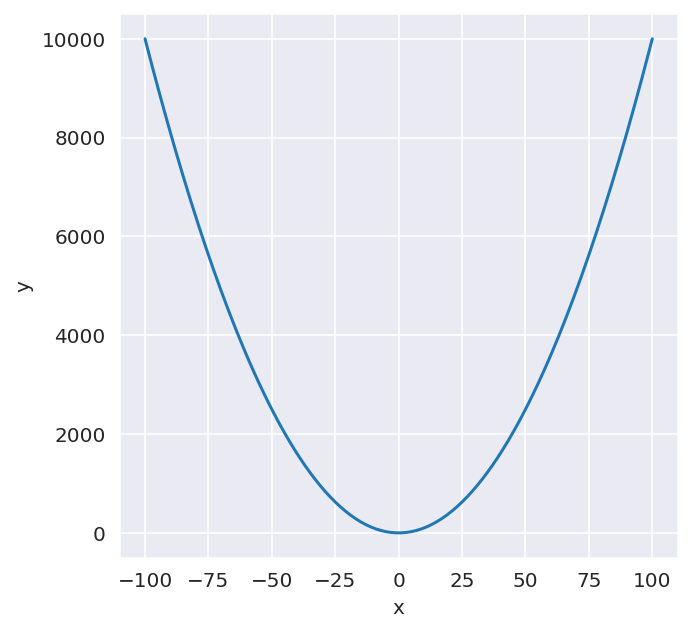

In [34]:
x = np.linspace(-100,100,201)
y = (x**2) #this is the 1-dimensional version of the Sphere code

fig = plt.figure(figsize=(5,5)) # adjust figsize as needed for your display
plt.plot(x,y)
plt.xlabel('x');
plt.ylabel('y');


In [35]:
# Graph of Sphere with dimension n = 2
%run scripts/sphere2d.py

<Figure size 864x504 with 0 Axes>

As you can see, the Sphere function simply makes the bottom half of a sphere. But it's extensible into many dimensions, just like Rastrigin is. Let's create our objective function for Sphere with any number of dimensions, and test it with a couple of numpy arrays.

In [36]:
def obj_Sphere(x):
    x = np.array(x) # force a numpy arrray here so that the math below works
    return np.sum(x**2)

pop_size=10
ind_size = 20
lower=-100
upper=100

pop1 = np.random.uniform(low=lower, high=upper, size =(pop_size,ind_size))
fitness1 = ga.computeFitness(obj_Sphere, pop1)
print('fitness1', fitness1)

ind_size=5
pop2 = np.random.uniform(low=lower, high=upper, size =(pop_size,ind_size))
fitness2 = ga.computeFitness(obj_Sphere, pop2)

print('fitness2', fitness2)

fitness1 [68947.12017593 73497.01642168 33353.36223015 86856.08055284
 62118.48221192 73647.99747839 72654.12130158 71453.68764307
 61557.99198032 62507.82792822]
fitness2 [12188.95339126 16226.09502399 22352.20761652 22799.75668851
 18344.13093477  9239.9936803   5897.98978505 14372.72251773
 16370.36301795  5686.32993303]


You can see from the fitness values above, the more genes each individual has (the larger the ind_size) the larger the base fitness is. If the goal is to get a fitness of zero, you can see that it will be more challenging the more dimensions we incorporate. It will take longer for our code to run, and we're less likely to find the global optimum.

Let's look at using lists of parameters to make developing our code more user-friendly. We'll have an initial parameter at index 0 that uses a small population and a small individual to develop our code. Then we can "turn up the dial" once we have working code, by changing the index variable.

In [37]:
###Using lists of variables - note how they're called in the code with an index. We'll have 3 sets.
pop_size = [6, 100, 1000] # should be even due to the way we'll implement crossover
ind_size = [2, 5, 20] # determines number of input variables for Rastrigin and each individual
tourn_size = [2,3,3] # tournament size for selection
cx_prob = [0.8, .7, .8] # probability a pair of parents crossover to produce two children
mut_prob = [0.3,.2,.1] # probability an individual mutates
ind_prob = [0.1, .1, .2] # probability each variable in an individual mutates
num_iter = [10, 100, 200] # number of genetic algorithm mutations (may want the first set to be 1 to start)
update_iter =[1, 20, 50] # how often to display output
num_elite = [0, 1, 3] #how many of the original population to pass through to the next unchanged

#these stay the same for every iteration
bounds = [-100, 100] #lower and upper bounds for the decision variables
sigma = (bounds[1]-bounds[0])/6
alpha = .2

#current index to use - starting with index 0 - look for the places we've added [idx]
#change to idx 1 when you've got code that works, then idx 2 to run a large problem.
idx=0

#initialize population and fitness
pop = np.random.uniform(low=lower, high=upper, size =(pop_size[idx],ind_size[idx]))
fitness = ga.computeFitness(obj_Sphere, pop)

# initialize stats and output
stats, best_fitness, best_x = ga.initStats(fitness, pop, num_iter[idx])

#This is where the guts of the algorithm start
for iter in range(num_iter[idx]):
    
    # tournament selection
    pop = ga.sortPop(pop, fitness)#sort population

    selected_pop = ga.tournamentSelection(pop, tourn_size[idx])

    # blended crossover (mating)
    cx_pop = ga.blendedCrossover(selected_pop, cx_prob[idx], alpha, bounds)
    
    # gaussianMutation
    mut_pop = ga.gaussianMutation(cx_pop, mut_prob[idx], ind_prob[idx], bounds, sigma)
    
    #choose one of the following two options, based on the complexity of your problem
    # copy mutated pop
    #pop = mut_pop.copy()
    #or run elitism
    pop = ga.addElitism(pop, mut_pop, num_elite[idx])
    #re-calculate fitness
    fitness = ga.computeFitness(obj_Sphere, pop)
    
    # collect stats and output to screen
    stats, best_fitness, best_x = ga.updateStats(stats, fitness, best_x, pop, iter, update_iter[idx])


#####################
# Everything in the algorithm is done, and now we're just outputting the final result
#####################
print(f"The minimum value found of the sphere is {best_fitness:.4f}")
print("The location of that minimum is:")
print('(',', '.join(f"{x:.4f}" for x in best_x),')')

Iteration | Best this iter |    Best ever
        1 |      1.490e+03 |    1.490e+03
        2 |      1.440e+03 |    9.396e+02
        3 |      1.440e+03 |    9.396e+02
        4 |      1.440e+03 |    9.396e+02
        5 |      1.440e+03 |    9.396e+02
        6 |      1.440e+03 |    9.396e+02
        7 |      1.440e+03 |    9.396e+02
        8 |      1.440e+03 |    9.396e+02
        9 |      1.081e+03 |    9.396e+02
       10 |      4.578e+02 |    4.578e+02
The minimum value found of the sphere is 457.8295
The location of that minimum is:
( -20.1113, -7.3052 )


We can add a local minimization routine at the end of our algorithm to further fine-tune our results. We use scipy optimize's minimize function to incorporate local search. We'll use "best_x" as our starting point and do another local optimization.

In [38]:
####################
# Add location optimization at the end
####################
result = minimize(obj_Sphere, best_x)
print(f"The minimum value found of the sphere is {result.fun:.4f}")
print("The location of that minimum is:")
print('(',', '.join(f"{x:.4f}" for x in result.x),')')


The minimum value found of the sphere is 0.0000
The location of that minimum is:
( -0.0000, -0.0000 )


### Binary Variables

Binary variables are a special case of integer variables with only 0 and 1 allowed.  

It is common to represent the binary variables as 0 and 1 or as False and True boolean variables.  Either one can be used in the homework.

**Example Binary Variable Initialization:**

The following code demonstrates two ways to create binary populations.  Recall that when specifying a range of integers in Python most packages and data structures don't include the top number in the range.

In [39]:
##Binary population of 5 individuals with 5 genes
pop_size = 6
ind_size = 4

# 0 and 1
pop = np.random.randint(0,2,size=(pop_size,ind_size))
# False and True
pop = np.random.randint(0,2,size=(pop_size,ind_size)).astype(bool)
pop

array([[ True, False,  True,  True],
       [ True, False,  True,  True],
       [ True,  True, False, False],
       [ True, False, False,  True],
       [ True,  True, False,  True],
       [False,  True,  True,  True]])

**Example Binary Variable Mating/Crossover**

One Point Crossover is common here. Remember to return your values as booleans.

In [40]:
cx_prob =.8

cx_pop = ga.onePointCrossover(pop, cx_prob, debug=True).astype(bool)
cx_pop

Crossover happened between Individuals 0 and 1 at point 3
Crossover happened between Individuals 2 and 3 at point 2
Crossover happened between Individuals 4 and 5 at point 3


array([[ True, False,  True,  True],
       [ True, False,  True,  True],
       [ True, False, False, False],
       [ True,  True, False,  True],
       [False,  True,  True,  True],
       [ True,  True, False,  True]])

Mutations are commonly called "flipping a bit" because 0's are toggled to 1's and 1's to 0's.  In a bit flipping mutation each variable is randomly switched with probability `ind_prob`.

The helper function for this is called bitFlipMutation. It takes in the population, the mut_prob, the ind_prob and an optional debug flag.

In [41]:
#review documenation for ga.bitFlipMutation
?ga.bitFlipMutation

Signature: ga.bitFlipMutation(pop, mut_prob, ind_prob, debug=False)
Docstring:
Peforms bit-flipping mutation on boolean populations.

Parameters:
pop (numpy array, required): The population, individuals as rows
mut_prob (real between 0 and 1, required): The probability that any individual will mutate
ind_prob (real between 0 and 1, required): The probability that a gene will mutate
debug (boolean, optional, default=False): Flag to indicate whether to output debugging print statements.

Returns: 
Population of boolean variables
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


In [42]:
mut_prob = 1 #set high for demonstration
ind_prob = .5
mut_pop = ga.bitFlipMutation(cx_pop, mut_prob, ind_prob, debug=True)
mut_pop

Gene 3 in Individual 0 flipped.
Gene 0 in Individual 1 flipped.
Gene 2 in Individual 1 flipped.
Gene 3 in Individual 1 flipped.
Gene 0 in Individual 2 flipped.
Gene 1 in Individual 2 flipped.
Gene 3 in Individual 2 flipped.
Gene 1 in Individual 3 flipped.
Gene 2 in Individual 3 flipped.
Gene 3 in Individual 3 flipped.
Gene 2 in Individual 4 flipped.
Gene 0 in Individual 5 flipped.
Gene 2 in Individual 5 flipped.
Gene 3 in Individual 5 flipped.


array([[ True, False,  True, False],
       [False, False, False, False],
       [False,  True, False,  True],
       [ True, False,  True, False],
       [False,  True, False,  True],
       [False,  True,  True, False]])

### Permutation Variables 

Permutations are sets of unique numbers in which order matters. These can come from problems where we are looking for the best order for a process of some kind.  For instance, in the Traveling Salesperson Problem we are trying to find the order to visit cities 1 through 7 (and back to 1) that minimizes the total distance traveled.  The crossover and mutation operators we've discussed so far don't work in this situation. And, initializing the population is slightly different as well.

**Example Permutation Variable Initialization**

For this example, we'll make a population of 4 individuals, with permutations from 0 to 5 in each row.

In [43]:
#remember that if want up to 5, we need to set the ind_size to 6
ind_size = 6
pop_size = 4
#first we make the empty array
pop = np.empty((pop_size,ind_size),dtype=int)
#then we fill it with permutations
for j in range(pop_size):
    pop[j] = np.random.permutation(ind_size).astype(int)

#view the population
pop

array([[1, 5, 4, 2, 3, 0],
       [0, 4, 1, 5, 3, 2],
       [3, 5, 4, 0, 2, 1],
       [5, 1, 4, 0, 3, 2]])

**Example Permutation Variable Crossover - Ordered Crossover**

A commonly used form of crossover is called Ordered Crossover in which two subsequences are swapped between the parents and the remainder of the variables filled in by preserving the order of variables.  The video below gives an example of how this works.

In [44]:
play_video("ds775_lesson5_ordered-crossover")

The next cell contains code (also discussed in the video) that demonstrates ordered crossover.

In [45]:
# Ordered Crossover on Sequences in Numpy
parent1 = np.array([0, 1, 2, 3, 4, 5, 6])
parent2 = np.array([3, 5, 6, 2, 0, 4, 1])

ind_size = parent1.shape[0]

# uncomment the line below to choose subsequence randomly in your code
# swap_idx = np.sort(np.random.randint(0,ind_size,2))

# delete this for your code, we want a fixed sequence for our example
swap_idx = np.array([ 3, 5]) # subseq in positions 3 through 5 inclusive

# A - important to copy these in reverse order
child1,child2 = parent2.copy(), parent1.copy()
# end A

# B - These four lines are the actual crossover
hole = np.full( ind_size, False, dtype = bool)
swap_idx = np.sort(np.random.randint(0,ind_size,2))
hole[swap_idx[0]:swap_idx[1]+1] = True
child1[~hole] = np.array([x for x in parent1 if x not in parent2[hole]])
child2[~hole] = np.array([x for x in parent2 if x not in parent1[hole]])
# end B

print(hole)
print(parent1[hole])
print(parent2[hole])
print(parent1,parent2)
print(child1,child2)

[False False  True  True  True  True False]
[2 3 4 5]
[6 2 0 4]
[0 1 2 3 4 5 6] [3 5 6 2 0 4 1]
[1 3 6 2 0 4 5] [6 0 2 3 4 5 1]


We provided an orderedCrossover function for you to call. It takes in the population, the cx_prob, and the debug flag, and returns the crossed population. 

In [46]:
#review documenation for ga.orderedCrossover
?ga.orderedCrossover

Signature: ga.orderedCrossover(pop, cx_prob, debug=False)
Docstring:
Peforms ordered crossover on permutation populations.

Parameters:
pop (numpy array of permutations, required): The population of permutations, individuals as rows
cx_prob (real between 0 and 1, required): The probability that any two individuals will mate
debug (boolean, optional, default=False): Flag to indicate whether to output debugging print statements.

Returns: 
Population of integers
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


In [47]:
cx_prob = .8
cx_pop = ga.orderedCrossover(pop, cx_prob, True)
cx_pop

Crossover happened for individual 0
Parent 1 [1 5 4 2 3 0]
Parent 2 [0 4 1 5 3 2]
Swap Index: [1 4]
Hole [False  True  True  True  True False]
Child1 [2 4 1 5 3 0]
Child2 [0 5 4 2 3 1]
Crossover happened for individual 1
Parent 1 [3 5 4 0 2 1]
Parent 2 [5 1 4 0 3 2]
Swap Index: [0 0]
Hole [ True False False False False False]
Child1 [5 3 4 0 2 1]
Child2 [3 5 1 4 0 2]


array([[2, 4, 1, 5, 3, 0],
       [0, 5, 4, 2, 3, 1],
       [5, 3, 4, 0, 2, 1],
       [3, 5, 1, 4, 0, 2]])

**Example Permutation Variable Mutation - Shuffling Indices**

For mutation of permutation variables it is common to use Shuffling Indices.  To do so just make a copy of the individual then loop over each variable and with probability `ind_prob` swap it with another randomly selected variable in the individual.  It's possible that you may end up swapping a variable with itself, but that's OK.

We've created a function for you called `shuffleMutation` that takes in the population, the mut_prob, the ind_prob, and the optional debug flag and returns the mutated population.

In [48]:
#review the documentation for ga.shuffleMutation
?ga.shuffleMutation

Signature: ga.shuffleMutation(pop, mut_prob, ind_prob, debug=False)
Docstring:
Peforms index shuffling mutation on permutation populations.

Parameters:
pop (numpy array, required): The population, individuals as rows
mut_prob (real between 0 and 1, required): The probability that any individual will mutate
ind_prob (real between 0 and 1, required): The probability that a gene will mutate
debug (boolean, optional, default=False): Flag to indicate whether to output debugging print statements.

Returns: 
Population of permutation integer variables
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


In [49]:
mut_prob = .8 #set high for demonstration
ind_prob = .5
mut_pop = ga.shuffleMutation(cx_pop, mut_prob, ind_prob, True).astype(int)
print('Population before mutation')
print(cx_pop)
print('\n\nPopulation after mutation')
print(mut_pop)

Pop size: 4
Individual size: 6
Gene 1 in Individual 0 swapped with 0
Individual before
 [2 4 1 5 3 0]
Individual after
 [4 2 1 5 3 0]
Gene 3 in Individual 0 swapped with 2
Individual before
 [4 2 1 5 3 0]
Individual after
 [4 2 5 1 3 0]
Gene 4 in Individual 0 swapped with 5
Individual before
 [4 2 5 1 3 0]
Individual after
 [4 2 5 1 0 3]
Gene 0 in Individual 1 swapped with 0
Individual before
 [0 5 4 2 3 1]
Individual after
 [0 5 4 2 3 1]
Gene 3 in Individual 1 swapped with 0
Individual before
 [0 5 4 2 3 1]
Individual after
 [2 5 4 0 3 1]
Gene 4 in Individual 1 swapped with 2
Individual before
 [2 5 4 0 3 1]
Individual after
 [2 5 3 0 4 1]
Gene 5 in Individual 1 swapped with 3
Individual before
 [2 5 3 0 4 1]
Individual after
 [2 5 3 1 4 0]
Gene 0 in Individual 2 swapped with 4
Individual before
 [5 3 4 0 2 1]
Individual after
 [2 3 4 0 5 1]
Gene 1 in Individual 2 swapped with 1
Individual before
 [2 3 4 0 5 1]
Individual after
 [2 3 4 0 5 1]
Gene 2 in Individual 2 swapped with 3
Indi

**Example Permutation Variable Mutation - Reversing Segments**

While shuffling indices is common, it doesn't work especially well for the Traveling Salesman Problem that you'll encounter in the homework (see <a href="https://arxiv.org/pdf/1203.3099.pdf">this paper</a> for more info).

The mutation is very similar to the `sub_tour_reversal` that we used with simulated annealing and local search, but for the genetic algorithm there may be multiple reversed segments since we loop over the cities in the tour and use it as an endpoint of reversed segment with probability `ind_prob.`

We've created a function for you called `flipSegmentsMutation` that takes in the population, the mut_prob, the ind_prob, and the optional debug flag and returns the mutated population.

In [50]:
#review the documentation for ga.flipSegmentsMutation
?ga.flipSegmentsMutation

Signature: ga.flipSegmentsMutation(pop, mut_prob, ind_prob, debug=False)
Docstring:
Performs multiple random segment reversal on permutation populations

Parameters:
pop (numpy array, required):  The population, individuals
mut_prob (real between 0 and 1, required): The probability an individual will mutate
ind_prob (real between 0 and 1, required): The probability a gene will be part of a segment reversal
File:      ~/Lessons/Lesson 07 - Global Optimization 2/GAUtilities.py
Type:      function


In [51]:
mut_prob = 1 #set high for demonstration
ind_prob = .1
mut_pop = ga.flipSegmentsMutation(cx_pop, mut_prob, ind_prob, True).astype(int)
print('pop before mutation')
print(cx_pop)
print('pop after mutation')
print(mut_pop)

pop before mutation
[[2 4 1 5 3 0]
 [0 5 4 2 3 1]
 [5 3 4 0 2 1]
 [3 5 1 4 0 2]]
pop after mutation
[[2 4 1 5 3 0]
 [0 5 4 2 3 1]
 [5 3 4 0 2 1]
 [3 5 1 4 0 2]]


If you don't see some reversed segments in the mutated population, try running the cell again.

### Tuning your Genetic Algorithm
In addition to using different selection, crossover, and mutation approaches, we can also tune our genetic algorithm by changing the values of various parameters used in the algorithm. Below is a table that lists the parameters and which ones can be tuned.

#### Adjustable Parameters Overview


<table >
	<tbody>
		<tr>
            <td><b>parameter</b></td>
            <td><b>variable name</b></td>
            <td><b>lower bound</b></td>
            <td><b>upper bound</b></td>
            <td><b>typical value(s)</b></td>
		</tr>
		<tr>
			<td>population size</td>
			<td><code>pop_size</code></td>
			<td>2</td>
			<td>none</td>
			<td>number of variables * (5 to 20)</td>
		</tr>
		<tr>
			<td>individual size</td>
			<td><code>ind_size</code></td>
			<td>NA</td>
			<td>NA</td>
			<td>always = number of variables</td>
		</tr>
		<tr>
			<td>lower bound for real var.</td>
			<td><code>lower</code></td>
			<td>NA</td>
			<td>NA</td>
			<td>problem dependent</td>
		</tr>
		<tr>
			<td>upper bound for real var. </td>
			<td><code>upper</code></td>
			<td>NA</td>
			<td>NA</td>
			<td>problem dependent</td>
		</tr>
		<tr>
			<td>tournament size for selection</td>
			<td><code>tourn_size</code></td>
			<td>1</td>
			<td><code>pop_size</code></td>
			<td>3 to 5</td>
		</tr>
		<tr>
			<td>crossover probability</td>
			<td><code>cx_prob</code></td>
			<td>0.0</td>
			<td>1.0</td>
			<td>0.8</td>
		</tr>
        <tr>
			<td>mutation probability</td>
			<td><code>mut_prob</code></td>
			<td>0.0</td>
			<td>1.0</td>
			<td>0.2</td>
		</tr>
		<tr>
			<td>single var. mutation prob.</td>
			<td><code>ind_prob</code></td>
			<td>0.0</td>
			<td>1.0</td>
			<td>0.05 to 0.1</td>
		</tr>
		<tr>
			<td>real var. mutation size</td>
			<td><code>sigma</code> </td>
			<td>0.0</td>
			<td>none</td>
			<td>(upper-lower)/6</td>
		</tr>
		<tr>
			<td>number of iterations</td>
			<td><code>num_iter</code></td>
			<td>1</td>
			<td>none</td>
			<td>problem dependent</td>
		</tr>
		<tr>
			<td>update to screen interval</td>
			<td><code>update_iter</code></td>
			<td>1</td>
			<td><code>num_iter</code></td>
			<td><code>num_iter/20</code></td>
		</tr>
	</tbody>
</table>


#### *Self-Assessment:  Genetic Algorithm for the Value Balancing Problem*

For this problem we'll apply the genetic algorithm to the Value Balancing Problem we visited in Lessons 5 and 6.  In the cell below we have the code for creating the values of 1000 items and also the fitness function we're trying to minimize.  Mimic the genetic algorithm from above to minimize the differences in the total values 

To make the genetic algorithm work, you'll need to pay attention to the following:
* The initial population should be individuals of length 1000 (`tot_num_items`) each having integer values between 0 and 3 with repeats allowed (there are `num_groups = 4` box cars to sort items into).  Use `numpy.random.randint`
* You can use onePointCrossover to mate individuals.  That part of the code doesn't need to change at all.  
* Use the uniformIntMutation() for mutation.
* Pay attention to the order of parameters in your objective function. Note that our algorithm expects the X values first, and any other parameters can be passed in as named variables.
* The objective function is `group_fitness` and is provided below for convenience along with code to generate a set of values that can be perfectly balanced for testing.
* Consider reducing the tot_num_items for testing your algorithm so the code runs faster.  Remember to push it back to 1000 for your final runs.
* Experiment with the algorithm parameters.  Can you find parameters that routinely achieve minimum fitness $\leq 20.$

In [52]:
# problem data and fitness function - DO NOT CHANGE
np.random.seed(123)
tot_num_items = 1000 # should be divisible by 4
num_items = int(tot_num_items / 4)
num_groups = 4
values = np.random.randint(10,100,size=num_items)
values = np.hstack([values,values,values,values])
np.random.seed()

def group_fitness(groups,values,num_groups):
    # groups must be a numpy array with ind_size entries (only one individual)
    sums = np.array([ sum( values[ groups == i] ) for i in range(num_groups) ])
    return max(sums)-min(sums)